In [1]:
import pickle
import warnings
import random
import torch

import numpy as np
import pandas as pd

from tqdm import tqdm
from glob import glob
from collections import OrderedDict
from scipy.spatial import distance
from scipy import stats
from sklearn import decomposition
from annoy import AnnoyIndex

from torch.nn import functional as F

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

%matplotlib inline

In [3]:
warnings.simplefilter('ignore')
alt.data_transformers.enable('default', max_rows=None)
pd.options.display.max_rows = 200

In [4]:
embeds, rows = [], []

for path in tqdm(glob('../../data/clean-embeds/*.p')):
    with open(path, 'rb') as fh:
        
        lines = pickle.load(fh)

        for line in lines:
            title = ' '.join(line.pop('tokens'))
            embeds.append(line.pop('embedding'))
            rows.append(OrderedDict(title=title, **line))

100%|██████████| 66/66 [00:26<00:00,  2.52it/s]


In [5]:
embeds = np.stack(embeds)

In [6]:
df = pd.DataFrame(rows)

In [7]:
df.label.unique()

array(['dailycaller.com', 'bloomberg.com', 'thehill.com',
       'huffingtonpost.com', 'dailykos.com', 'nytimes.com', 'cnn.com',
       'wsj.com', 'apnews.com', 'breitbart.com', 'foxnews.com',
       'washingtonpost.com', 'buzzfeed.com'], dtype=object)

In [8]:
embeds.shape

(651589, 512)

In [9]:
center = embeds.mean(0)

In [10]:
def ds_from_center(domain, metric):
    
    ds = []
    for v in embeds[df[df.label==domain].index]:
        ds.append(metric(center, v))
        
    return ds

In [11]:
domains = df.label.unique()

In [19]:
def plot_step_hist(ds):
    
    plt.figure(figsize=(15,10))

    ys, x, _ = plt.hist(
        ds.values(),
        label=ds.keys(),
        histtype='step',
        bins=100,
        linewidth=2,
    )

    plt.legend(loc='upper right')
    
    return x, ys

In [13]:
def plot_step_hist_interactive(x, ys):

    rows = []
    for y, domain in zip(ys, ds.keys()):
        for d, count in zip(x[:-1], y):
            rows.append((domain, d, count))

    hist_df = pd.DataFrame(rows, columns=('domain', 'd', 'count'))
    
    highlight = alt.selection(
        type='single',
        on='mouseover',
        fields=['domain'],
        nearest=True,
    )

    base = (alt
        .Chart(hist_df, width=700, height=500)
        .encode(x=alt.X('d', scale=alt.Scale(zero=False)), y='count', color='domain'))

    points = (base
        .mark_circle()
        .encode(opacity=alt.value(0))
        .add_selection(highlight)
        .properties(width=600))

    lines = (base
        .mark_line()
        .encode(size=alt.condition(~highlight, alt.value(2), alt.value(5)), tooltip='domain'))

    return points + lines

In [14]:
def plot_ds_violin(ds):

    rows = []
    for domain, dds in ds.items():
        for d in dds:
            rows.append((domain, d))
            
    ds_df = pd.DataFrame(rows, columns=('domain', 'd'))
    
    order = ds_df.groupby('domain').mean().sort_values('d', ascending=False).index
    plt.figure(figsize=(5,10))
    sns.violinplot(y='domain', x='d', data=ds_df.sample(frac=0.01), order=order)

In [15]:
ds = {
    d: ds_from_center(d, distance.cosine)
    for d in tqdm(domains)
}

100%|██████████| 13/13 [00:36<00:00,  2.78s/it]


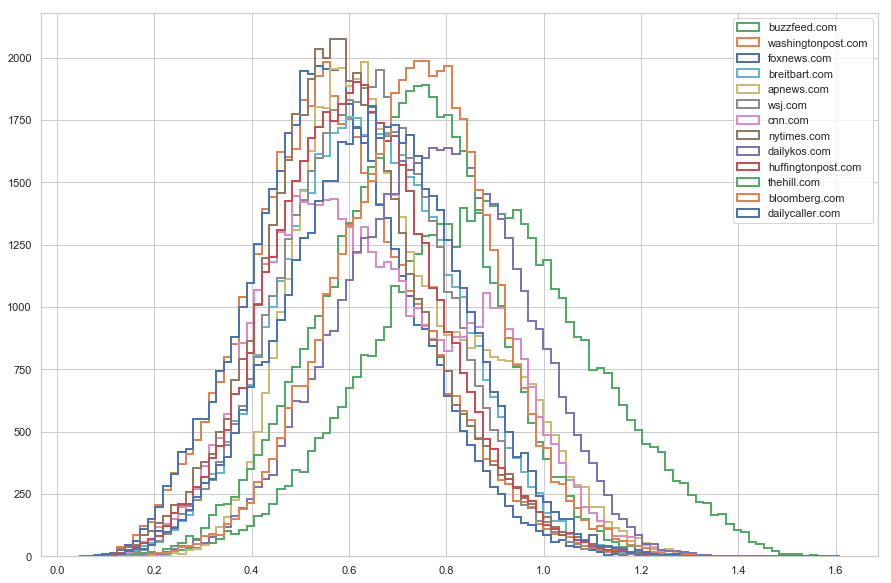

In [20]:
x, ys = plot_step_hist(ds)

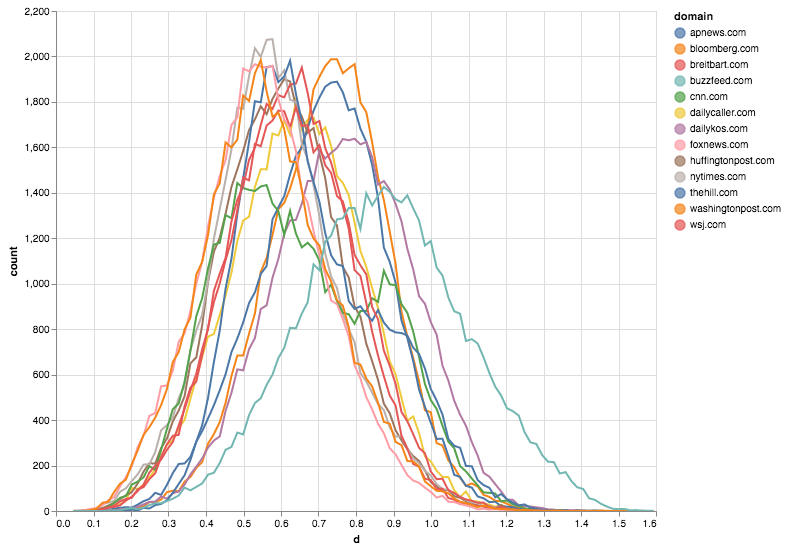

In [21]:
plot_step_hist_interactive(x, ys)

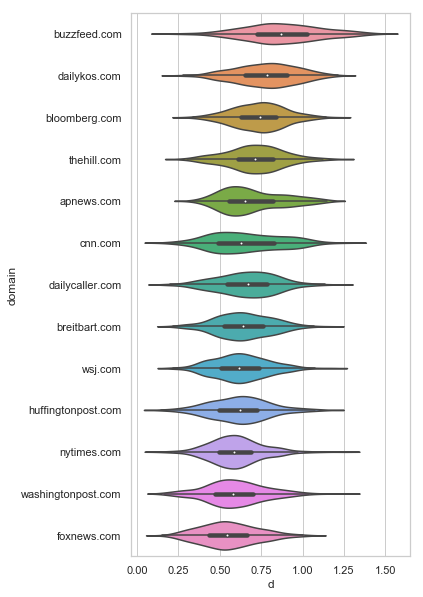

In [22]:
plot_ds_violin(ds)

In [23]:
ds = {
    d: ds_from_center(d, distance.euclidean)
    for d in tqdm(domains)
}

100%|██████████| 13/13 [00:12<00:00,  1.06it/s]


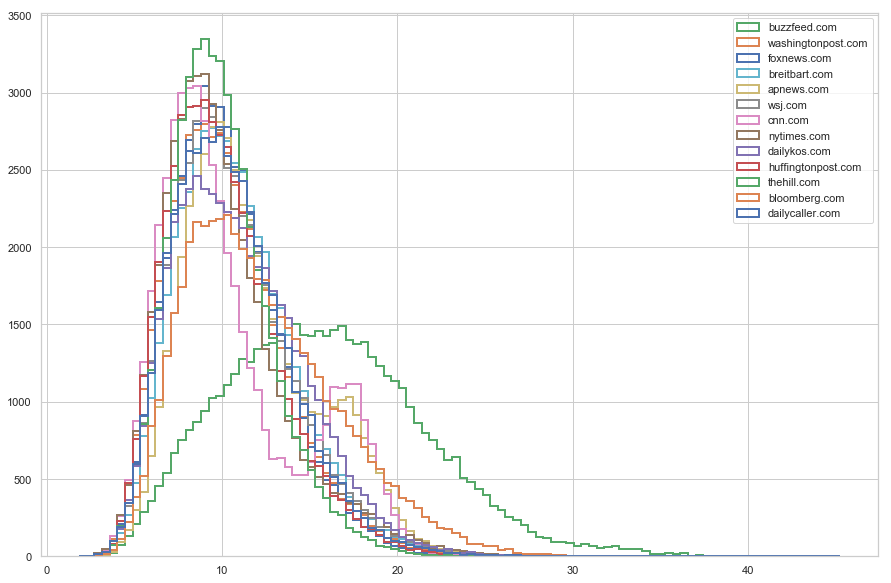

In [24]:
x, ys = plot_step_hist(ds)

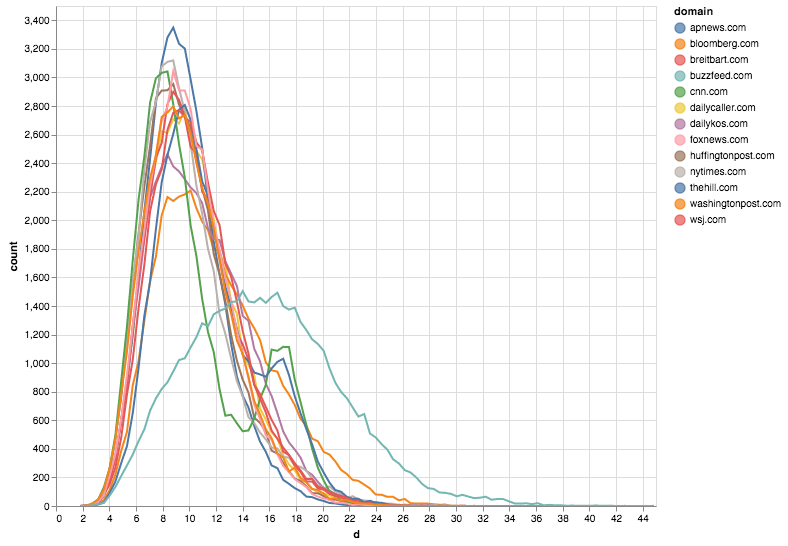

In [25]:
plot_step_hist_interactive(x, ys)

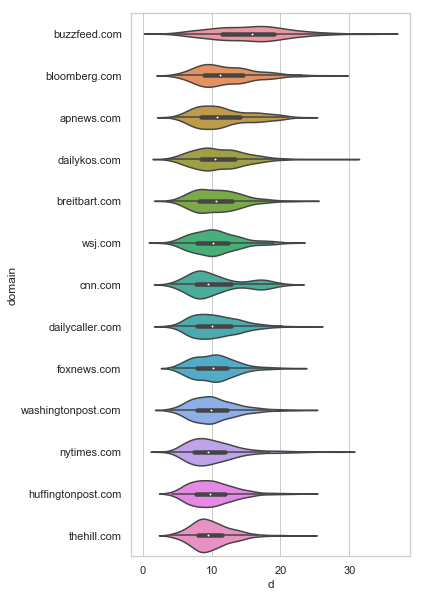

In [27]:
plot_ds_violin(ds)

In [28]:
idx = AnnoyIndex(embeds.shape[1])

for i in tqdm(range(len(embeds))):
    idx.add_item(i, embeds[i])
    
idx.build(10)

100%|██████████| 651589/651589 [00:50<00:00, 13011.92it/s]


True

In [29]:
for id in idx.get_nns_by_vector(center, 20):
    print(df.iloc[id].title)

how bashar al assad gassed his own people
former rockies marlins pitcher dies in venezuela amid lack of medication
basketball star duncan and troops aid islands devastated by irma
grandfather apologizes after dylann roof s guilty pleas add to sentence
gunman in cincinnati kills three before police fatally shoot him
ann wedgeworth # dies tony winning actress known for three s company
mother accused of fatally stabbing family gives thumbs up in court
white sox catcher castillo gets # game performance enhancing drug suspension
dan rooney emerged from father s shadow to make steelers into winners
youth soccer club silences sidelines muting parents for weekend of quiet
suspect breaks into off duty officer s home dies from gunshot wound
# baltimore high schools no students proficient in math report says
stevie wonder and others to perform at aretha franklin s funeral
yemeni families mourn at new cemetery built for children killed in air strike
bruce arena replacing jurgen klinsmann as us coa